# XGBoost Article

The functions are based on the XGBoost Classification article from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## Import Libraries:

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import sklearn
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

## Load Data:




In [2]:
# Let's setup our fuel consumption data from 2010 to july 2017
fuel = pd.read_csv('Fuel Efficiciency/Fuel_FO_2010-17_lr.csv', sep = ';',index_col=None,encoding='latin-1')

In [3]:
# Let's use all the data again
f= fuel
f['Lts_x_GTK'] = ((f['Liters'] * 1000)/ (f['Gross_Ton_km'] / 1000000)).astype(float)
f['GTK_9'] = ((f['Gross_Ton_km'] / 1000000000)).astype(float)
# create six dummy variables for track_id using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(f.Track_id, prefix='SD').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
f = pd.concat([f, area_dummies], axis=1)

# create six dummy variables for Locomotive Type using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(f.Id_Model_Loc, prefix='MOD').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
f = pd.concat([f, area_dummies], axis=1)


# create six dummy variables for Train Type using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(f.Id_Sub_Type, prefix='TRN').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
f = pd.concat([f, area_dummies], axis=1)

# create a new Series called Tract - Number of Locomotives
f['Tract'] = f.Traccion.map({'S':1,'M':0})

# create a new Series called IsUnit
f['IsUnit'] = f.UTC.map({'UTR':1,'NUT':0,'PAS':-1})


In [4]:
#choose the predictor columns (X) with all the predictors and the dependent variable (y) Liters
feature_cols = ['GTK_9', 'Hours', 'Kilometers', 'IsUnit', 'Tract','SD_2', 'SD_3', 'SD_4', 'SD_5', 'SD_6', 
                'MOD_10', 'MOD_28', 'MOD_38', 'MOD_40', 'MOD_42', 'MOD_43', 
                'TRN_2', 'TRN_3', 'TRN_4', 'TRN_5', 'TRN_6', 'TRN_8', 'TRN_9', 'TRN_10', 'TRN_11']
X = f[feature_cols]
y = f.Liters

In [5]:
# Separate train and test set
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.33, random_state = 5)

In [6]:
#train = pd.read_csv('train_modified.csv')
#test = pd.read_csv('test_modified.csv')

In [7]:
X_train.shape, X_test.shape

((60285, 25), (29694, 25))

In [8]:
target= Y_train


In [9]:
Y_train.values

array([900, 110, 190, ..., 450,  20, 510], dtype=int64)

In [10]:
#Y_train.value_counts()

## Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine the explained variance
3. determine training MSE
4. determine testing MSE
5. update n_estimators with cv function of xgboost package
6. plot Feature Importance 

In [15]:
test_results = pd.read_csv('test_results.csv')
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=Y_train.values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], Y_train, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

        
    #Print model report:
    print ("\nModel Report")
    print ("Explained Variance : %.4g" % explained_variance_score(Y_train.values, dtrain_predictions))
    print ("RMSE Score (Train): %f" % mean_squared_error(Y_train, dtrain_predictions))
    
#     Predict on testing data:
    dtest_predictions = alg.predict(dtest[predictors])

    print ("Explained Variance : %.4g" % explained_variance_score(Y_test.values, dtest_predictions))
    print ('RMSE Score (Test): %f' % mean_squared_error(Y_test, dtest_predictions))

    

 
    feature_importance = alg.feature_importances_*100    
    feat_imp = pd.Series(feature_importance, index=dtrain.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Step 1- Find the number of estimators for a high learning rate


Model Report
Explained Variance : 0.7853
RMSE Score (Train): 46908.841691
Explained Variance : 0.7674
RMSE Score (Test): 51383.671093


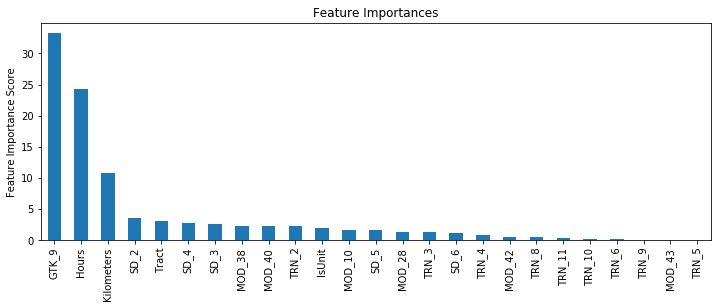

In [16]:
predictors = [x for x in X_train.columns]
xgb1 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, X_train, X_test, predictors)

In [58]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [63]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -51820.84255, std: 1639.98224, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -51875.88937, std: 1666.38522, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -51802.70554, std: 1629.39908, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -50306.33310, std: 1701.37428, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -50272.43160, std: 1716.03803, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -50274.15413, std: 1664.65985, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -50150.66807, std: 1686.76863, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -50154.48483, std: 1552.02871, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -49971.68100, std: 1555.12632, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -50720.98256, std: 1566.63778, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -50560.50747, std: 1610.71523, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -50316.41319, std: 1559.

In [83]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[6,7,8],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [6, 7, 8], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [84]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -50040.68431, std: 1626.66738, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -50029.88361, std: 1640.18738, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -50013.28541, std: 1554.32058, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -49985.08844, std: 1616.78979, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: -49971.68100, std: 1555.12632, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -50075.26631, std: 1607.16072, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: -50109.42627, std: 1546.50557, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: -50080.15296, std: 1583.94166, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -50103.21164, std: 1451.51202, params: {'max_depth': 8, 'min_child_weight': 6}],
 {'max_depth': 7, 'min_child_weight': 5},
 -49971.681000893514)

In [87]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[9,10,11]
}
gsearch2b = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=7,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [88]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -50020.40546, std: 1563.99608, params: {'min_child_weight': 9},
  mean: -49933.72703, std: 1572.90598, params: {'min_child_weight': 10},
  mean: -49946.21282, std: 1630.02844, params: {'min_child_weight': 11}],
 {'min_child_weight': 10},
 -49933.727029039386)

In [89]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=7,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=10, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [90]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -49933.72703, std: 1572.90598, params: {'gamma': 0.0},
  mean: -49933.72703, std: 1572.90598, params: {'gamma': 0.1},
  mean: -49933.72703, std: 1572.90598, params: {'gamma': 0.2},
  mean: -49933.72703, std: 1572.90598, params: {'gamma': 0.3},
  mean: -49933.72703, std: 1572.90598, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -49933.727029039386)

# XGBoosting

Recalibrate with the calculated parameters:


Model Report
Explained Variance : 0.7867
RMSE Score (Train): 46591.485265
Explained Variance : 0.7691
RMSE Score (Test): 51017.378981


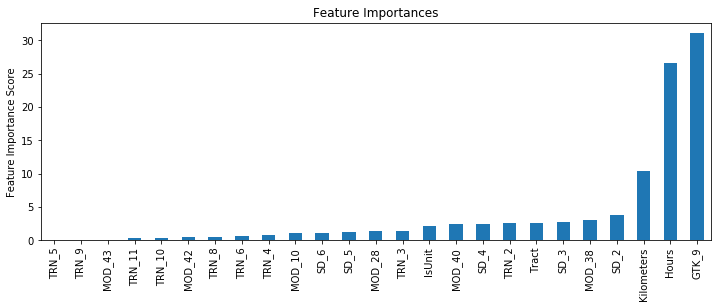

In [91]:
predictors = [x for x in X_train.columns]
xgb2 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=7,
        min_child_weight=10,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, X_train, X_test, predictors)


Tune subsample and colsample_bytree

In [92]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=7,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=10, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [93]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -50259.36286, std: 1573.91308, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -50127.10904, std: 1597.72760, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -50048.21353, std: 1579.79989, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -50047.95016, std: 1463.41267, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -50280.64497, std: 1614.89160, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -50113.42291, std: 1547.81614, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -50103.49579, std: 1537.54513, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -50024.50712, std: 1474.02732, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -50386.29142, std: 1636.11599, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -50151.70306, std: 1600.83043, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -50050.89869, std: 1552.28817, params: {'colsample_bytree': 0.8, 'subsam

tune subsample:

In [75]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [76]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -50624.47033, std: 1653.66459, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: -50610.69630, std: 1655.49922, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: -50626.48758, std: 1642.19318, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: -50674.33621, std: 1675.24980, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: -50585.79212, std: 1646.65365, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -50630.18534, std: 1618.46820, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: -50644.32655, std: 1672.18358, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: -50632.91731, std: 1659.48978, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: -50582.06944, std: 1647.43990, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.85, 'subsample': 0.85},
 -50582.069441612504)

change required

Try regularization:

In [94]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=7,
                                        min_child_weight=10, gamma=0, subsample=0.85, colsample_bytree=0.85,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=10, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.85),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [95]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -50002.22009, std: 1553.51619, params: {'reg_alpha': 1e-05},
  mean: -50015.72432, std: 1553.51802, params: {'reg_alpha': 0.01},
  mean: -49994.18616, std: 1544.44498, params: {'reg_alpha': 0.1},
  mean: -49976.99569, std: 1554.37875, params: {'reg_alpha': 1},
  mean: -50010.47752, std: 1523.01184, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -49976.995689680531)

In [98]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[1, 5, 10, 15, 20, 30]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1, 5, 10, 15, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [99]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -50585.81566, std: 1646.64200, params: {'reg_alpha': 1},
  mean: -50585.76683, std: 1656.60011, params: {'reg_alpha': 5},
  mean: -50578.32527, std: 1661.73391, params: {'reg_alpha': 10},
  mean: -50599.77302, std: 1682.07428, params: {'reg_alpha': 15},
  mean: -50616.67397, std: 1662.01821, params: {'reg_alpha': 20},
  mean: -50611.10902, std: 1639.46260, params: {'reg_alpha': 30}],
 {'reg_alpha': 10},
 -50578.325265803112)


Model Report
Explained Variance : 0.786
RMSE Score (Train): 46739.437583
Explained Variance : 0.7685
RMSE Score (Test): 51159.614331


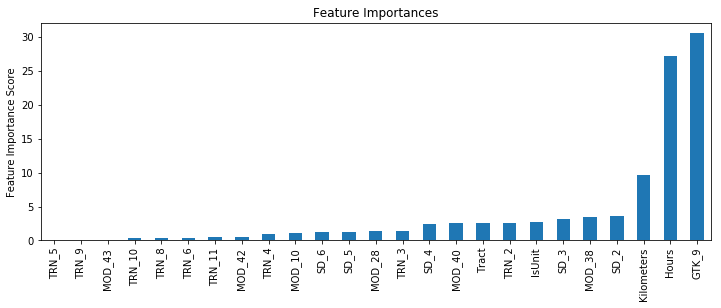

In [100]:
xgb3 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=7,
        min_child_weight=10,
        gamma=0,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=10,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, predictors)


Model Report
Explained Variance : 0.7881
RMSE Score (Train): 46290.979267
Explained Variance : 0.7698
RMSE Score (Test): 50863.885712


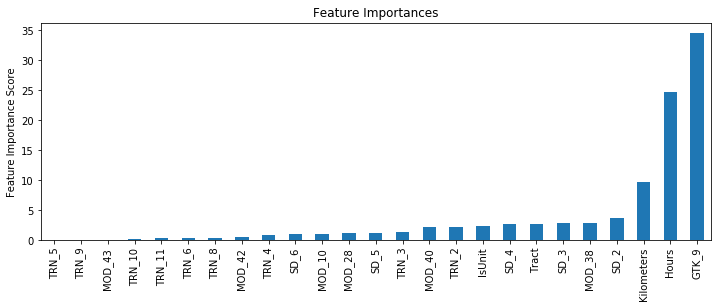

In [101]:
xgb4 = XGBRegressor(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=7,
        min_child_weight=10,
        gamma=0,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=10,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb4, X_train, X_test, predictors)

In [30]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test8 = {
#    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.30],
#    'n_estimators' = [100, 200, 300, 400, 500, 1000, 5000]
    'learning_rate':[0.001, 0.05, 0.075, 0.1],
    'n_estimators':[475, 500, 525]
}
gsearch8 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test8, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X_train[predictors],Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'learning_rate': [0.001, 0.05, 0.075, 0.1], 'n_estimators': [475, 500, 525]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [31]:
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

C:\Users\225648\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -269497.90229, std: 2307.33659, params: {'learning_rate': 0.001, 'n_estimators': 475},
  mean: -259474.67548, std: 2267.73932, params: {'learning_rate': 0.001, 'n_estimators': 500},
  mean: -249753.65935, std: 2223.87292, params: {'learning_rate': 0.001, 'n_estimators': 525},
  mean: -50478.44973, std: 1632.19110, params: {'learning_rate': 0.05, 'n_estimators': 475},
  mean: -50464.53662, std: 1627.51350, params: {'learning_rate': 0.05, 'n_estimators': 500},
  mean: -50441.70267, std: 1622.93660, params: {'learning_rate': 0.05, 'n_estimators': 525},
  mean: -50425.10885, std: 1622.05713, params: {'learning_rate': 0.075, 'n_estimators': 475},
  mean: -50408.79238, std: 1609.71142, params: {'learning_rate': 0.075, 'n_estimators': 500},
  mean: -50416.39872, std: 1617.18053, params: {'learning_rate': 0.075, 'n_estimators': 525},
  mean: -50511.78956, std: 1588.01930, params: {'learning_rate': 0.1, 'n_estimators': 475},
  mean: -50510.95198, std: 1586.02914, params: {'learning_rate